<div align="center">

<p align="center"> 
    <img
        src="./Assets/Turkaracter Logo.png"
        raw=true
        alt="turkaracter_Logo"
        style="width: 128px; height: 128px" />
</p>

# TurKaracter: Entwicklung eines Erkennungssystems von türkischen Handschriften unter Verwendung von künstlichen neuronalen Netzwerken
### Bachelor Abschlussarbeit von Abdurrahman ODABAŞI
### Betreuer: Dr. Ahmet YILDIZ (Türkisch-Deutsche Universität)
### Industriepartner: BIS Çözüm Bilgisayar ve Entegrasyon Hiz. ve Tic. A.Ş.
#### Bearbeitungszeitraum 04.11.2021 - 20.06.2022

</div>

## 0. Imports & Setup

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 0.1. Helper Functions

#### 0.1.1. Save the Figures

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### 0.1.2. Label to Actual Value (Decoding)

In [3]:
def decodeLabel(value):
    if value <= 9:
        return(chr(value+48))
    elif value > 9 and value < 36:
        return(chr(value+55))
    elif value > 35 and value < 62:
        return(chr(value+61))
    elif value > 61 and value < 72:
        turkishDecoder = {
            62:286 , #Ğ
            63:304 , #İ
            64:214 , #Ö
            65:220 , #Ü
            66:231 , #ç
            67:287 , #ğ
            68:305 , #ı
            69:246 , #ö
            70:351 , #ş
            71:252  #ü
        }
        return (chr(turkishDecoder.get(value)))
    elif value > 71:
        # Labels for punctuation marks
        return 0

#### 0.1.3. Display the Image in the notebook instead of independent window (With the help of Matplotlib)

In [4]:
def displayImage(image): #Gray_Image with one Channel
    dpi = 80
    height, width = image.shape
    # What Size does the figure need to be in inches to fit the image
    figSize = width/float(dpi), height/float(dpi)

    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')

    ax.imshow(image, cmap="gray")
    plt.show()

def displayColouredImage(image):
    dpi = 80
    rgb_image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    height, width, depth = rgb_image.shape
    # What Size does the figure need to be in inches to fit the image
    figSize = width/float(dpi), height/float(dpi)

    fig = plt.figure(figsize=figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')

    ax.imshow(rgb_image, cmap="gray")
    plt.show()

## 1. Datasets Loading

### 1.0. EMNIST

In [5]:
a=['Label']

for i in range(784):
    a.append('Pixel'+str(i+1))

emnist_train_path = './Datasets/Emnist/emnist-byclass-train.csv'
emnist_train_df = pd.read_csv(emnist_train_path, delimiter=',', names=a)
print('Shape of Training dataset: ', emnist_train_df.shape)
# emnist_test_path = './Datasets/Emnist/emnist-byclass-test.csv'
# emnist_test_df = pd.read_csv(emnist_test_path, delimiter=',', names=a)
# print('Shape of Test dataset: ', emnist_test_df.shape)

emnist_train_df.head()

Shape of Training dataset:  (697932, 785)


,Label,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784
0,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_emnist_train_df = emnist_train_df.copy()
y_emnist_train_df = X_emnist_train_df.pop('Label')

# X_emnist_test_df = emnist_test_df.copy()
# y_emnist_test_df = X_emnist_test_df.pop('Label')

X_emnist_train_df = np.array(X_emnist_train_df)
X_emnist_train_df = X_emnist_train_df[:, :].reshape(-1, 28, 28)
y_emnist_train_df = np.array(y_emnist_train_df)
y_emnist_train_df = y_emnist_train_df[..., np.newaxis]

print(X_emnist_train_df.shape)
print(y_emnist_train_df.shape)

(697932, 28, 28)
(697932, 1)


Saving figure EMNIST Datapoints


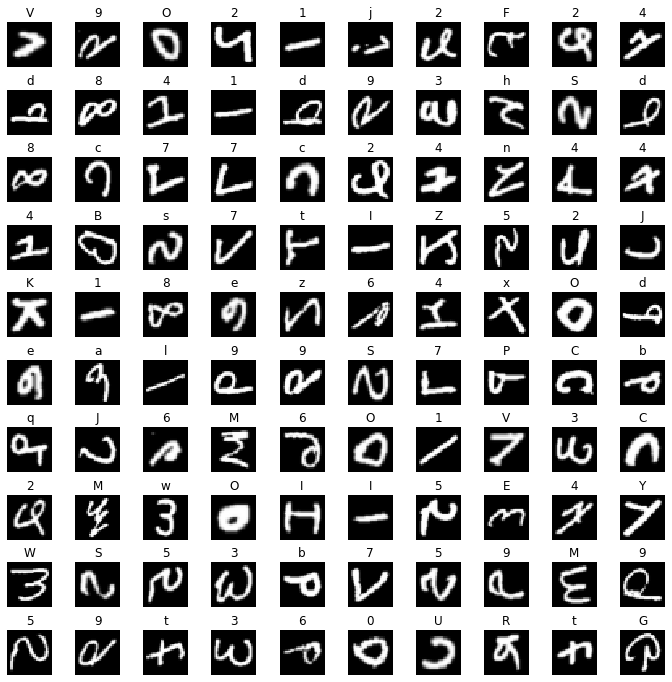

In [9]:
n_rows = 10
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_emnist_train_df[index+70], cmap="gray", interpolation="nearest")
        plt.axis('off')
        plt.title(decodeLabel(int(y_emnist_train_df[index+70])), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('EMNIST - Datapoints', tight_layout=False)
plt.show()

### 1.1. Original NIST19

#### 1.1.1. Loading the dataset

In [10]:
training_data = []
training_labels = []
for index in range(62):
    print("Reading Data of Class", decodeLabel(index))
    #setting the path to the directory containing the pics
    path = f"./Datasets/NIST19/{index}/"
    for img in os.listdir(path):
        pic = cv2.imread(os.path.join(path,img))
        height, width, _ = pic.shape
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        pic = cv2.bitwise_not(pic)
        pic = cv2.resize(pic,(28,28))
        new_pic = np.asarray(pic)
        new_pic = new_pic.reshape(-1)
        training_data.append(new_pic)
        training_labels.append([str(index)])

    print("Completed, ", len(training_data), " Datapoints read!")
    print("Completed, ", len(training_labels), " Labels read!")
    print("==================================================")

print(len(training_data))
training_data = np.asarray(training_data)
print(training_data.shape)
training_labels = np.asarray(training_labels)
print(training_labels.shape)

Reading Data of Class 0
Completed,  34803  Datapoints read!
Completed,  34803  Labels read!
Reading Data of Class 1
Completed,  72852  Datapoints read!
Completed,  72852  Labels read!
Reading Data of Class 2
Completed,  107036  Datapoints read!
Completed,  107036  Labels read!
Reading Data of Class 3
Completed,  142329  Datapoints read!
Completed,  142329  Labels read!
Reading Data of Class 4
Completed,  175761  Datapoints read!
Completed,  175761  Labels read!
Reading Data of Class 5
Completed,  206828  Datapoints read!
Completed,  206828  Labels read!
Reading Data of Class 6
Completed,  240907  Datapoints read!
Completed,  240907  Labels read!
Reading Data of Class 7
Completed,  276703  Datapoints read!
Completed,  276703  Labels read!
Reading Data of Class 8
Completed,  310587  Datapoints read!
Completed,  310587  Labels read!
Reading Data of Class 9
Completed,  344307  Datapoints read!
Completed,  344307  Labels read!
Reading Data of Class A
Completed,  351317  Datapoints read!
Com

In [11]:
X_nist_original = training_data
y_nist_original = training_labels

In [222]:
np.save("./Datasets/X_nist_original.npy", X_nist_original)
np.save("./Datasets/y_nist_original.npy", y_nist_original)

#### 1.1.2. Plotting the class distribution of the dataset

Plotting Labels over the bars
https://stackoverflow.com/questions/55586912/seaborn-catplot-set-values-over-the-bars

In [15]:
upper_letters_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
lower_letters_names = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
digits_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

upper_letters_frequecies = [ np.count_nonzero(y_nist_original == str(x)) for x in range(10,36,1) ]

upper_data = {
    'Upper Case Letters': upper_letters_names,
    '#Data Points': upper_letters_frequecies
    }
upper_freq_df = pd.DataFrame(upper_data)

lower_letters_frequecies = [ np.count_nonzero(y_nist_original == str(x)) for x in range(36,62,1) ]

lower_data = {
    'Lower Case Letters': lower_letters_names,
    '#Data Points': lower_letters_frequecies
    }
lower_freq_df = pd.DataFrame(lower_data)

digits_frequecies = [ np.count_nonzero(y_nist_original == str(x)) for x in range(0,10,1) ]

digits_data = {
    'Digits': digits_names,
    '#Data Points': digits_frequecies
    }
digits_freq_df = pd.DataFrame(digits_data)

Saving figure NIST19 - Upper Case with Average
Saving figure NIST19 - Lower Case with Average
Saving figure NIST19 - Digits with Average


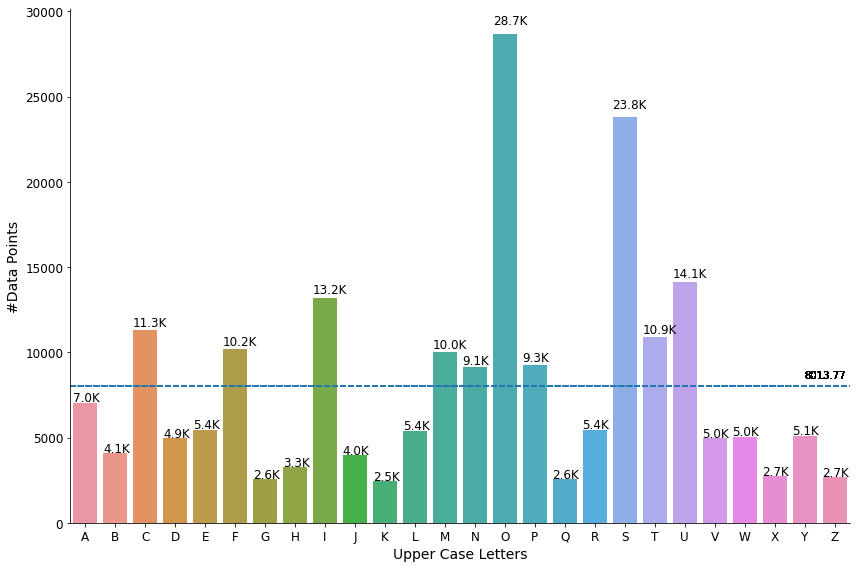

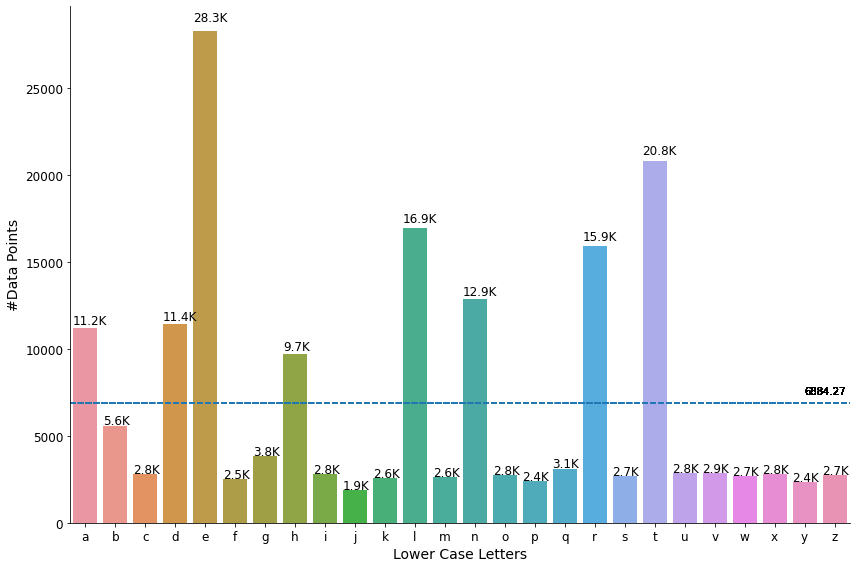

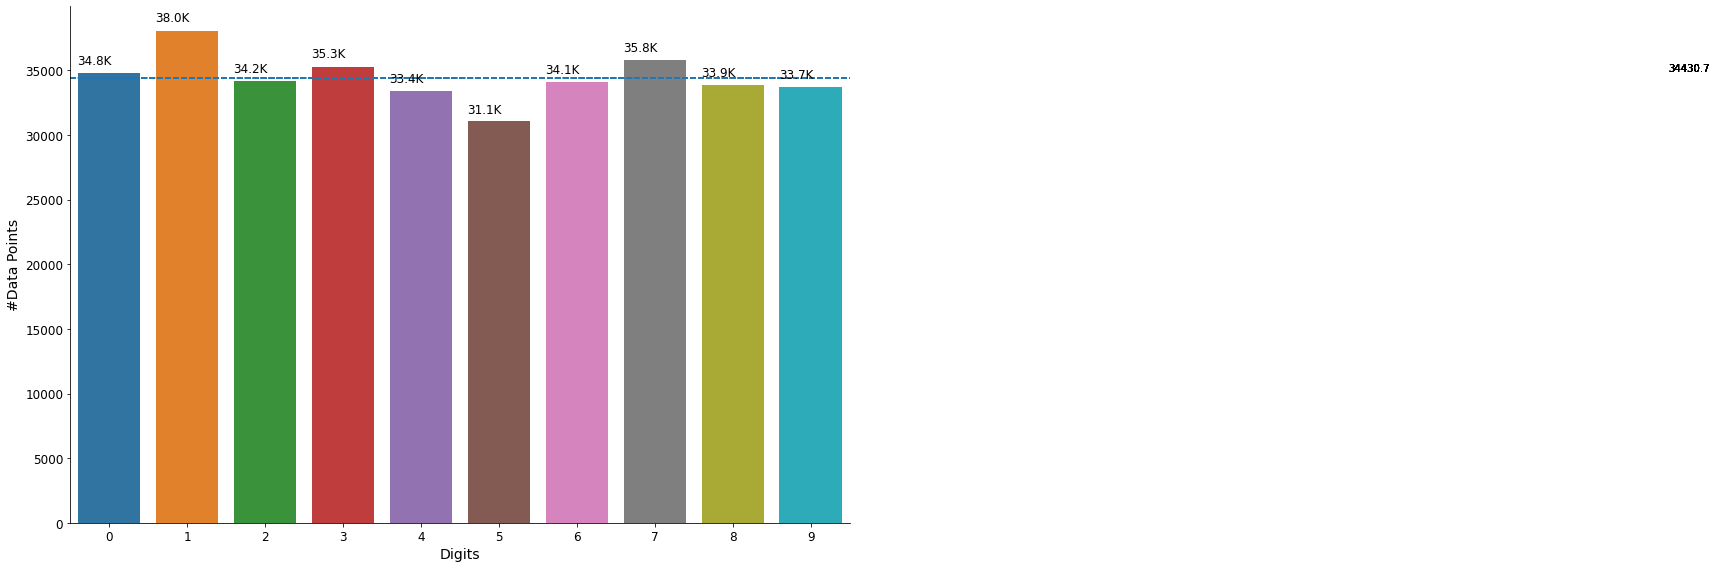

In [16]:
upper_average = sum(upper_letters_frequecies) / len(upper_letters_frequecies)
lower_average = sum(lower_letters_frequecies) / len(lower_letters_frequecies)
digits_average = sum(digits_frequecies) / len(digits_frequecies)

upper_freq_catplot = sns.catplot(x="Upper Case Letters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=upper_freq_df, legend=True)
upper_freq_catplot.set_yticklabels(fontsize=12, rotation=0)
ax1 = upper_freq_catplot.facet_axis(0,0)
for p in ax1.patches:
        ax1.text(p.get_x() - 0.01,
                p.get_height() * 1.02,
                '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
                color='black',
                rotation='horizontal',
                size='large')
        ax1.axhline(upper_average, ls='--')
        ax1.text(24, upper_average+500, round(upper_average, 2))
save_fig('NIST19 - Upper Case with Average', tight_layout=False)

lower_freq_catplot = sns.catplot(x="Lower Case Letters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=lower_freq_df)
lower_freq_catplot.set_yticklabels(fontsize=12, rotation=0)
ax2 = lower_freq_catplot.facet_axis(0,0)
for p in ax2.patches:
        ax2.text(p.get_x() - 0.01,
                p.get_height() * 1.02,
                '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
                color='black',
                rotation='horizontal',
                size='large')
        ax2.axhline(lower_average, ls='--')
        ax2.text(24, lower_average+500, round(lower_average, 2))
save_fig('NIST19 - Lower Case with Average', tight_layout=False)

digits_freq_catplot = sns.catplot(x="Digits", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=digits_freq_df)
digits_freq_catplot.set_yticklabels(fontsize=12, rotation=0)
ax3 = digits_freq_catplot.facet_axis(0,0)
for p in ax3.patches:
        ax3.text(p.get_x() - 0.01,
                p.get_height() * 1.02,
                '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
                color='black',
                rotation='horizontal',
                size='large')
        ax3.axhline(digits_average, ls='--')
        ax3.text(20, digits_average+500, round(digits_average, 2))
save_fig('NIST19 - Digits with Average', tight_layout=False)

### 1.2. Cropped And Resized NIST19 (With OpenCV)

#### 1.2.1. Methods of Cropping the dataset and rescale the characters to the size of their images

Crop Image Padding (With OpenCV)

In [17]:
def cropImagePaddingAndResize(image, img_dimension=28, kernel_height=5 ,kernel_width=5): #image is a Gray_Image with one Channel
    kernel = np.ones((kernel_height,kernel_width), dtype='uint8')
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    contours, hierarchies = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_lines = sorted(contours, key=lambda contour: cv2.contourArea(contour))
    x, y, w, h = cv2.boundingRect(sorted_contour_lines[-1]) #Accepting only the biggest Contour
    image=image[y:y+h, x:x+w]

    # Resize Image to img_dimension minus margin with respect to the aspect ratio of the image
    height, width = image.shape
    if height > width:
        if height > img_dimension:
            new_height = img_dimension-4 # -4 as margin
            aspect_ratio = height / width
            new_width = int(new_height / aspect_ratio)
            image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)    #Resize To Smaller Image
            return image
        else:
            new_height = img_dimension-4 # -4 as margin
            aspect_ratio = height / width
            new_width = int(new_height / aspect_ratio)
            image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)   #Resize To Bigger Image
            return image
    else:
        if width > img_dimension:
            new_width = img_dimension-4 # -4 as margin
            aspect_ratio = width / height
            new_height = int(new_width / aspect_ratio)
            image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)    #Resize To Smaller Image
            return image
        else:
            new_width = img_dimension-4 # -4 as margin
            aspect_ratio = width / height
            new_height = int(new_width / aspect_ratio)
            image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)   #Resize To Bigger Image
            return image

Repair Image Shape (Adding Padding to reach img_dimension)

In [18]:
# Adding black pixels to the margin
def repairShape(image, img_dimension=28): #image is a Gray_Image with one Channel
    height, width = image.shape
    if height % 2 != 0:
        top = int((img_dimension-height)/2)+1
        bottom = int((img_dimension-height)/2)
        if width % 2 != 0:
            left = int((img_dimension-width)/2)+1
            right = int((img_dimension-width)/2)
            image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=0)
            return image
        else:
            left = int((img_dimension-width)/2)
            right = int((img_dimension-width)/2)
            image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=0)
            return image
    else:
        top = int((img_dimension-height)/2)
        bottom = int((img_dimension-height)/2)
        if width % 2 != 0:
            left = int((img_dimension-width)/2)+1
            right = int((img_dimension-width)/2)
            image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=0)
            return image
        else:
            left = int((img_dimension-width)/2)
            right = int((img_dimension-width)/2)
            image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,value=0)
            return image

#### 1.2.2. Cropping and rescaling the dataset and then saving

In [ ]:
for index in range(62):
    print("Reading Data of Class", decodeLabel(index))
    #setting the path to the directory containing the pics
    path = f"./Datasets/NIST19/{index}/"

    for img in os.listdir(path):
        pic = cv2.imread(os.path.join(path,img))

        # Preprocessing the image
        height, width, _ = pic.shape
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        pic = cv2.bitwise_not(pic)

        # Cropping the extra padding of the images
        pic = cropImagePaddingAndResize(pic)
        pic = repairShape(pic)


        pathOfDataset = f"./Datasets/NIST19CroppedS/"
        #creating new directory with the name of the class in the folder of the new dataset
        os.makedirs(os.path.join(pathOfDataset, str(index)), exist_ok=True)
        pathOfClassFolder = os.path.join(pathOfDataset, str(index))
        # Saving the new version of the data
        cv2.imwrite(os.path.join(pathOfClassFolder,img), pic)

#### 1.2.3. Loading the cropped dataset

In [20]:
#appending the pics to the training data list
training_data = []
training_labels = []

for index in range(62):
    print("Reading Data of Class", decodeLabel(index))

    #setting the path to the directory containing the pics
    path = f"./Datasets/NIST19Cropped/{index}/"

    for img in os.listdir(path):
        pic = cv2.imread(os.path.join(path,img))
        height, width, _ = pic.shape
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        new_pic = np.asarray(pic)
        new_pic = new_pic.reshape(-1)
        training_data.append(new_pic)
        training_labels.append([str(index)])

    print("Completed, ", len(training_data), " Datapoints read!")
    print("Completed, ", len(training_labels), " Labels read!")
    print("==================================================")


print(len(training_data))
training_data = np.asarray(training_data)
print(training_data.shape)
training_labels = np.asarray(training_labels)
print(training_labels.shape)

Reading Data of Class 0
Completed,  34803  Datapoints read!
Completed,  34803  Labels read!
Reading Data of Class 1
Completed,  72852  Datapoints read!
Completed,  72852  Labels read!
Reading Data of Class 2
Completed,  107036  Datapoints read!
Completed,  107036  Labels read!
Reading Data of Class 3
Completed,  142329  Datapoints read!
Completed,  142329  Labels read!
Reading Data of Class 4
Completed,  175761  Datapoints read!
Completed,  175761  Labels read!
Reading Data of Class 5
Completed,  206828  Datapoints read!
Completed,  206828  Labels read!
Reading Data of Class 6
Completed,  240907  Datapoints read!
Completed,  240907  Labels read!
Reading Data of Class 7
Completed,  276703  Datapoints read!
Completed,  276703  Labels read!
Reading Data of Class 8
Completed,  310587  Datapoints read!
Completed,  310587  Labels read!
Reading Data of Class 9
Completed,  344307  Datapoints read!
Completed,  344307  Labels read!
Reading Data of Class A
Completed,  351315  Datapoints read!
Com

In [21]:
X_nist_opencv_cropped = training_data
y_nist_opencv_cropped = training_labels

In [223]:
np.save("./Datasets/X_nist_opencv_cropped.npy", X_nist_opencv_cropped)
np.save("./Datasets/y_nist_opencv_cropped.npy", y_nist_opencv_cropped)

### 1.3. Zoomed NIST19 (With keras.layers.RandomZoom)

#### Warning:

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code.

Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output with Keras preprocessing layers.

For more information:

    1- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    2- https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
    3- https://www.tensorflow.org/tutorials/images/data_augmentation
    4- https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom

Blog about ImageDataGenerator:

    - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#### Zooming the dataset and then saving

In [160]:
X_nist_original = np.load("./Datasets/X_nist_original.npy")
y_nist_original = np.load("./Datasets/y_nist_original.npy")

tf.keras.layers.RandomZoom(
    height_factor,
    width_factor=None,
    fill_mode='reflect',
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,
    **kwargs
)

height_factor:  a float represented as fraction of value, or a tuple of size 2 representing lower and upper bound for zooming vertically. When represented as a single float, this value is used for both the upper and lower bound. A positive value means zooming out, while a negative value means zooming in. For instance, height_factor=(0.2, 0.3) result in an output zoomed out by a random amount in the range [+20%, +30%]. height_factor=(-0.3, -0.2) result in an output zoomed in by a random amount in the range [+20%, +30%].

width_factor: a float represented as fraction of value, or a tuple of size 2 representing lower and upper bound for zooming horizontally. When represented as a single float, this value is used for both the upper and lower bound. For instance, width_factor=(0.2, 0.3) result in an output zooming out between 20% to 30%. width_factor=(-0.3, -0.2) result in an output zooming in between 20% to 30%. Defaults to None, i.e., zooming vertical and horizontal directions by preserving the aspect ratio.

fill_mode: Points outside the boundaries of the input are filled according to the given mode (one of {"constant", "reflect", "wrap", "nearest"}).

    - reflect: (d c b a | a b c d | d c b a) The input is extended by reflecting about the edge of the last pixel.
    - constant: (k k k k | a b c d | k k k k) The input is extended by filling all values beyond the edge with the same constant value k = 0.
    - wrap: (a b c d | a b c d | a b c d) The input is extended by wrapping around to the opposite edge.
    - nearest: (a a a a | a b c d | d d d d) The input is extended by the nearest pixel.

interpolation: Interpolation mode. Supported values: "nearest", "bilinear".

seed: Integer. Used to create a random seed.

fill_value: a float represents the value to be filled outside the boundaries when fill_mode="constant".

In [204]:
zoomer = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(.25, seed=42) # the zooming range will be between [1-.25, 1+.25] => [0.75, 1.25]
])

In [206]:
X_nist_original_reshaped = X_nist_original.reshape(-1, 28, 28)
X_nist_original_reshaped.shape

(731656, 28, 28)

In [214]:
X_nist_random_zoomed = zoomer(X_nist_original_reshaped)
X_nist_random_zoomed = X_nist_random_zoomed.numpy()
X_nist_random_zoomed = X_nist_random_zoomed.reshape(-1, 784)


(731656, 28, 28)
(731656, 784)


In [216]:
y_nist_random_zoomed = y_nist_original

In [224]:
np.save("./Datasets/X_nist_keras_random_zoomed.npy", X_nist_random_zoomed)
np.save("./Datasets/y_nist_keras_random_zoomed.npy", y_nist_random_zoomed)

### 1.4. T-H-E

##### 1.4.1. Loading the dataset

In [25]:
a=['Label']

for i in range(784):
    a.append('Pixel'+str(i+1))

# Only Original Character Version
the_path = './Datasets/T-H-E/version6.csv'
the_df = pd.read_csv(the_path, delimiter=',', names=a)
print('Shape of complete dataset: ', the_df.shape)

the_df.head()

Shape of complete dataset:  (76000, 785)


,Label,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784
0,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
the_df["Label"].value_counts()

63    1000
15    1000
75    1000
12    1000
76    1000
      ... 
39    1000
40    1000
41    1000
42    1000
64    1000
Name: Label, Length: 76, dtype: int64

In [27]:
the_df['Label'].value_counts().index.tolist()

[63,
 15,
 75,
 12,
 76,
 13,
 77,
 14,
 78,
 16,
 62,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 11,
 74,
 10,
 73,
 1,
 65,
 2,
 3,
 67,
 4,
 68,
 5,
 6,
 70,
 7,
 71,
 8,
 72,
 9,
 24,
 25,
 26,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 46,
 44,
 27,
 43,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 64]

Extracting only the data of the turkish characters from the whole dataset

In [28]:
turkish_classes = [27, 28, 29, 30, 31, 32, 67, 68, 70, 71]
the_tr_df = the_df[the_df["Label"].isin(turkish_classes)]
print('Shape of complete dataset: ', the_tr_df.shape)
the_tr_df.reset_index(drop=True)

Shape of complete dataset:  (10000, 785)


,Label,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784
0,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,71,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,71,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,71,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,71,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 1.4.2. Plotting the class distribution of the dataset

In [29]:
letters_names = ["Ö", "ö", "İ", "ı", "Ü", "ü", "Ğ", "ğ", "ç", "ş"] # Ş und Ç fehlen
frequecies = [
                the_tr_df['Label'].value_counts()[70],
                the_tr_df['Label'].value_counts()[31],
                the_tr_df['Label'].value_counts()[68],
                the_tr_df['Label'].value_counts()[29],
                the_tr_df['Label'].value_counts()[71],
                the_tr_df['Label'].value_counts()[32],
                the_tr_df['Label'].value_counts()[67],
                the_tr_df['Label'].value_counts()[28],
                the_tr_df['Label'].value_counts()[27],
                the_tr_df['Label'].value_counts()[30],
            ]

data = {
    'Letters': letters_names,
    '#Data Points': frequecies
    }
freq_df = pd.DataFrame(data)

Saving figure T-H-E (Except Ş, Ç)


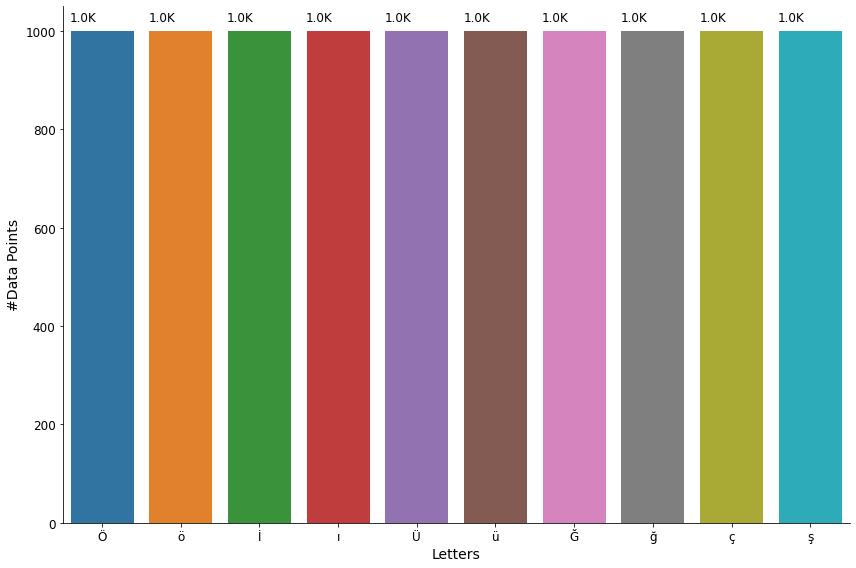

In [30]:
freq_catplot = sns.catplot(x="Letters", y="#Data Points", kind="bar", height=8, aspect=1.5, orient='v',  data=freq_df)
freq_catplot.set_yticklabels(fontsize=12, rotation=0)
ax4 = freq_catplot.facet_axis(0,0)
for p in ax4.patches:
    ax4.text(p.get_x() - 0.01,
            p.get_height() * 1.02,
            '{0:.1f}K'.format(p.get_height()/1000),   #Used to format it K representation
            color='black',
            rotation='horizontal',
            size='large')

save_fig('T-H-E (Except Ş, Ç)', tight_layout=False)

##### 1.4.3. Changing Labels into Extended ASCII (with Unicode UCS-2 Character Encoding)

To make the conversion between numerical label and the actual character value easier, the UCS-2 Character encoding is better to use than another encodings as Python is built with UCS2 Unicode, and the built-in functions `ord()` and `chr()` can do the all work on converting between actual characters and encoded values.

For more, see the following:
- [The whole UCS-2 Unicode code chart](http://www.columbia.edu/kermit/ucs2.html)
- [The function ord()](https://www.geeksforgeeks.org/ord-function-python/)
- [The function chr()](https://www.geeksforgeeks.org/chr-in-python/)

In [31]:
the_tr_df = the_tr_df.replace({'Label' : {68:63, 70:64, 71:65, 67:62}})
the_tr_df = the_tr_df.replace({'Label' : {32:71, 27:66, 29:68, 31:69, 30:70, 28:67}})

In [32]:
the_tr_df.head()

,Label,Pixel1,Pixel2,Pixel3,Pixel4,Pixel5,Pixel6,Pixel7,Pixel8,Pixel9,...,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783,Pixel784
0,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X_the_tr_df = the_tr_df.copy()
y_the_tr_df = X_the_tr_df.pop('Label')

In [34]:
X_the_original = np.array(X_the_tr_df)
y_the_original = np.array(y_the_tr_df)

In [35]:
y_the_original = y_the_original[..., np.newaxis]

Plotting some examples of T-H-E Dataset

(10000, 28, 28)
Saving figure Augmented_THE_plot


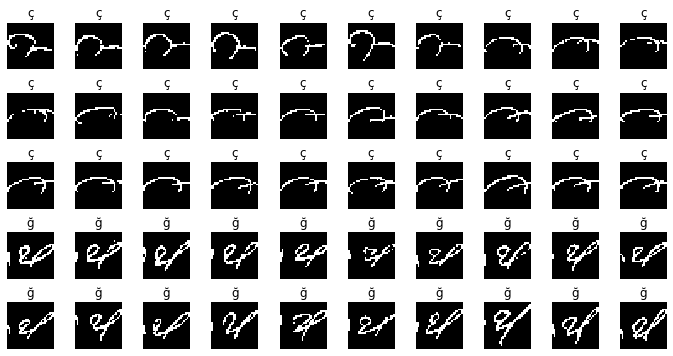

In [36]:
one_channel = X_the_original[:, :].reshape(-1, 28, 28)
print(one_channel.shape)

n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(one_channel[index+70], cmap="gray", interpolation="nearest")
        plt.axis('off')
        plt.title(decodeLabel(int(y_the_original[index+70])), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('Augmented_THE_plot', tight_layout=False)
plt.show()

In [37]:
# To get the original form of the data we must rotate the images 270' degrees anticlockwise along the last two axes and then flip them along axis 1 (horizontally)
X_the_original = X_the_original.reshape(-1, 28, 28)
X_the_original = np.rot90(X_the_original.reshape(-1, 28, 28), 3, (-2, -1))
X_the_original = np.flip(X_the_original, 2)

In [74]:
print(X_the_original.shape)

(10000, 28, 28)


Saving figure Original_THE_plot


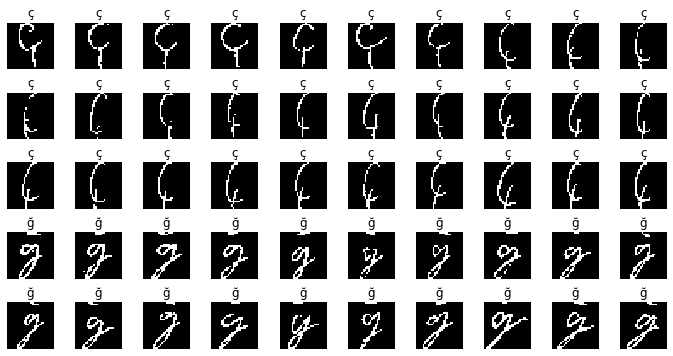

In [64]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_the_original[index+70], cmap="gray", interpolation="nearest")
        plt.axis('off')
        plt.title(decodeLabel(int(y_the_original[index+70])), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('Original_THE_plot', tight_layout=False)
plt.show()

In [40]:
print(X_the_original.shape)
print(y_the_original.shape)

(10000, 28, 28)
(10000, 1)


Saving the corrected THE Dataset as Images

In [83]:
pathOfDataset = "./Datasets/CorrectedTHE/"
for index in range(X_the_original.shape[0]):
    #creating new directory with the name of the class in the folder of the corrected dataset
    os.makedirs(os.path.join(pathOfDataset, str(y_the_original[index].item(0))), exist_ok=True)
    pathOfClassFolder = os.path.join(pathOfDataset, str(y_the_original[index].item(0)))
    # Saving the new version of the data
    image = Image.fromarray((X_the_original[index] * 255).astype(np.uint8))
    image.save((pathOfClassFolder+"/"+str(index)+".png"))

In [221]:
np.save("./Datasets/X_the_original.npy", X_the_original)
np.save("./Datasets/y_the_original.npy", y_the_original)

### 1.5. Padded T-H-E

##### 1.5.1. Loading and processing the dataset

In [146]:
from ImageProcessingMethods import addPadding
import random

IMG_DIMENSION = 28

#appending the pics to the training data list
training_data = []
training_labels = []

for index in range(62,72,1):
    print("Reading Data of Class", decodeLabel(index))

    #setting the path to the directory containing the pics
    path = f"./Datasets/CorrectedTHE/{index}/"

    for img in os.listdir(path):
        pic = cv2.imread(os.path.join(path,img))
        height, width, _ = pic.shape
        # Grayscaling
        pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        # Scaling to smaller Dimensions (Here: to 24X24)
        new_height = IMG_DIMENSION-4 # -4 as margin
        aspect_ratio = height / width
        new_width = int(new_height / aspect_ratio)
        # # Widing Examples of Ş
        # if index == 70:
        #     widing_proba = random.random()
        #     if widing_proba < 0.2:
        #         new_width += 2
        pic = cv2.resize(pic, (new_width, new_height), interpolation=cv2.INTER_AREA)
        pic = addPadding(pic)
        pic = cv2.threshold(pic, 80, 255, cv2.THRESH_BINARY)[1]
        # Dilating Datapoints with randomness of 10% Probability
        dilate_proba = random.random()
        if dilate_proba < 0.1:
            pic = cv2.dilate(pic, (3,3), iterations=1)
        new_pic = np.asarray(pic)
        new_pic = new_pic.reshape(-1)
        training_data.append(new_pic)
        training_labels.append([str(index)])

    print("Completed, ", len(training_data), " Datapoints read!")
    print("Completed, ", len(training_labels), " Labels read!")
    print("==================================================")


print(len(training_data))
training_data = np.asarray(training_data)
print(training_data.shape)
training_labels = np.asarray(training_labels)
print(training_labels.shape)

Reading Data of Class Ğ
Completed,  1000  Datapoints read!
Completed,  1000  Labels read!
Reading Data of Class İ
Completed,  2000  Datapoints read!
Completed,  2000  Labels read!
Reading Data of Class Ö
Completed,  3000  Datapoints read!
Completed,  3000  Labels read!
Reading Data of Class Ü
Completed,  4000  Datapoints read!
Completed,  4000  Labels read!
Reading Data of Class ç
Completed,  5000  Datapoints read!
Completed,  5000  Labels read!
Reading Data of Class ğ
Completed,  6000  Datapoints read!
Completed,  6000  Labels read!
Reading Data of Class ı
Completed,  7000  Datapoints read!
Completed,  7000  Labels read!
Reading Data of Class ö
Completed,  8000  Datapoints read!
Completed,  8000  Labels read!
Reading Data of Class ş
Completed,  9000  Datapoints read!
Completed,  9000  Labels read!
Reading Data of Class ü
Completed,  10000  Datapoints read!
Completed,  10000  Labels read!
10000
(10000, 784)
(10000, 1)


In [156]:
X_the_padded = training_data
y_the_padded = training_labels

Plotting some examples of Padded T-H-E Dataset

(10000, 28, 28)
Saving figure Padded_THE_plot


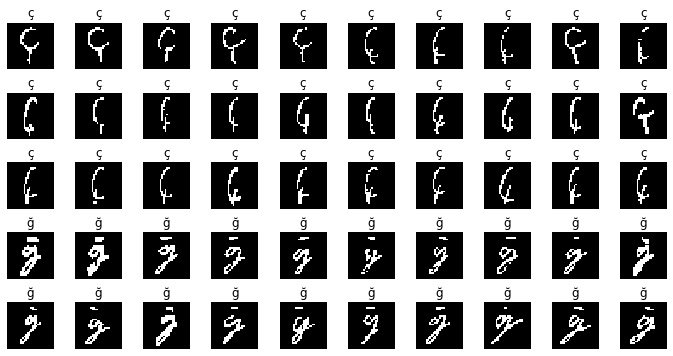

In [157]:
one_channel = X_the_padded[:, :].reshape(-1, 28, 28)
print(one_channel.shape)

n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(one_channel[index+4970], cmap="gray", interpolation="nearest")
        plt.axis('off')
        plt.title(decodeLabel(int(y_the_padded[index+4970])), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('Padded_THE_plot', tight_layout=False)
plt.show()

In [158]:
X_the_padded = X_the_padded.reshape(-1, 28, 28)
print(X_the_padded.shape)
print(y_the_padded.shape)

(10000, 28, 28)
(10000, 1)


In [220]:
np.save("./Datasets/X_the_padded.npy", X_the_padded)
np.save("./Datasets/y_the_padded.npy", y_the_padded)

## 2. Combining the datasets

### 2.1. Reshaping

In [218]:
print("Shape of X_nist_original", X_nist_original.shape)
print("Shape of y_nist_original", y_nist_original.shape)
print("Shape of X_nist_opencv_cropped", X_nist_opencv_cropped.shape)
print("Shape of y_nist_opencv_cropped", y_nist_opencv_cropped.shape)
print("Shape of X_nist_random_zoomed", X_nist_random_zoomed.shape)
print("Shape of y_nist_random_zoomed", y_nist_random_zoomed.shape)
print("Shape of X_the_original", X_the_original.shape)
print("Shape of y_the_original", y_the_original.shape)
print("Shape of X_the_padded", X_the_padded.shape)
print("Shape of y_the_padded", y_the_padded.shape)

Shape of X_nist_original (731656, 784)
Shape of y_nist_original (731656, 1)
Shape of X_nist_opencv_cropped (731650, 784)
Shape of y_nist_opencv_cropped (731650, 1)
Shape of X_nist_random_zoomed (731656, 784)
Shape of y_nist_random_zoomed (731656, 1)
Shape of X_the_original (10000, 28, 28)
Shape of y_the_original (10000, 1)
Shape of X_the_padded (10000, 28, 28)
Shape of y_the_padded (10000, 1)


In [228]:
X_nist_original = X_nist_original[:, :].reshape(-1, 28, 28)
X_nist_original = X_nist_original[..., np.newaxis]
X_nist_opencv_cropped = X_nist_opencv_cropped[:, :].reshape(-1, 28, 28)
X_nist_opencv_cropped = X_nist_opencv_cropped[..., np.newaxis]
X_nist_random_zoomed = X_nist_random_zoomed[:, :].reshape(-1, 28, 28)
X_nist_random_zoomed = X_nist_random_zoomed[..., np.newaxis]
X_the_original = X_the_original[..., np.newaxis]
X_the_padded = X_the_padded[..., np.newaxis]

In [231]:
print("Shape of X_nist_original", X_nist_original.shape)
print("Shape of y_nist_original", y_nist_original.shape)
print("Shape of X_nist_opencv_cropped", X_nist_opencv_cropped.shape)
print("Shape of y_nist_opencv_cropped", y_nist_opencv_cropped.shape)
print("Shape of X_nist_random_zoomed", X_nist_random_zoomed.shape)
print("Shape of y_nist_random_zoomed", y_nist_random_zoomed.shape)
print("Shape of X_the_original", X_the_original.shape)
print("Shape of y_the_original", y_the_original.shape)
print("Shape of X_the_padded", X_the_padded.shape)
print("Shape of y_the_padded", y_the_padded.shape)

Shape of X_nist_original (731656, 28, 28, 1)
Shape of y_nist_original (731656, 1)
Shape of X_nist_opencv_cropped (731650, 28, 28, 1)
Shape of y_nist_opencv_cropped (731650, 1)
Shape of X_nist_random_zoomed (731656, 28, 28, 1)
Shape of y_nist_random_zoomed (731656, 1)
Shape of X_the_original (10000, 28, 28, 1)
Shape of y_the_original (10000, 1)
Shape of X_the_padded (10000, 28, 28, 1)
Shape of y_the_padded (10000, 1)


### 2.2. Splitting to Training/Test Sets

In [ ]:
print("Shape of X_nist_original", X_nist_original.shape)
print("Shape of y_nist_original", y_nist_original.shape)
print("Shape of X_nist_opencv_cropped", X_nist_opencv_cropped.shape)
print("Shape of y_nist_opencv_cropped", y_nist_opencv_cropped.shape)
print("Shape of X_nist_random_zoomed", X_nist_random_zoomed.shape)
print("Shape of y_nist_random_zoomed", y_nist_random_zoomed.shape)
print("Shape of X_the_original", X_the_original.shape)
print("Shape of y_the_original", y_the_original.shape)
print("Shape of X_the_padded", X_the_padded.shape)
print("Shape of y_the_padded", y_the_padded.shape)

In [233]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(X_nist_original, y_nist_original): # 658490 training Instances & 73166 Test Instances = 731656 Total Instances
    X_nist_original_train, X_nist_original_test = X_nist_original[train_index], X_nist_original[test_index]
    y_nist_original_train, y_nist_original_test = y_nist_original[train_index], y_nist_original[test_index]

In [234]:
print(X_nist_original_train.shape)
print(y_nist_original_train.shape)
print(X_nist_original_test.shape)
print(y_nist_original_test.shape)

(658490, 28, 28, 1)
(658490, 1)
(73166, 28, 28, 1)
(73166, 1)


In [235]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(X_nist_opencv_cropped, y_nist_opencv_cropped): # 658490 training Instances & 73166 Test Instances = 731656 Total Instances
    X_nist_opencv_cropped_train, X_nist_opencv_cropped_test = X_nist_opencv_cropped[train_index], X_nist_opencv_cropped[test_index]
    y_nist_opencv_cropped_train, y_nist_opencv_cropped_test = y_nist_opencv_cropped[train_index], y_nist_opencv_cropped[test_index]

In [236]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42)
for train_index, test_index in splitter.split(X_nist_random_zoomed, y_nist_random_zoomed): # 658490 training Instances & 73166 Test Instances = 731656 Total Instances
    X_nist_random_zoomed_train, X_nist_random_zoomed_test = X_nist_random_zoomed[train_index], X_nist_random_zoomed[test_index]
    y_nist_random_zoomed_train, y_nist_random_zoomed_test = y_nist_random_zoomed[train_index], y_nist_random_zoomed[test_index]

In [237]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42) # 9000 training Instances & 1000 Test Instances
for train_index, test_index in splitter.split(X_the_original, y_the_original):
    X_the_original_train, X_the_original_test = X_the_original[train_index], X_the_original[test_index]
    y_the_original_train, y_the_original_test = y_the_original[train_index], y_the_original[test_index]

In [238]:
splitter = StratifiedShuffleSplit(train_size=0.9, test_size=0.1, random_state=42) # 9000 training Instances & 1000 Test Instances
for train_index, test_index in splitter.split(X_the_padded, y_the_padded):
    X_the_padded_train, X_the_padded_test = X_the_padded[train_index], X_the_padded[test_index]
    y_the_padded_train, y_the_padded_test = y_the_padded[train_index], y_the_padded[test_index]

In [283]:
np.save("X_the_padded_train.npy", X_the_padded_train)
np.save("X_the_padded_test.npy", X_the_padded_test)
np.save("y_the_padded_train.npy", y_the_padded_train)
np.save("y_the_padded_test.npy", y_the_padded_test)
np.save("X_the_original_train.npy", X_the_original_train)
np.save("X_the_original_test.npy", X_the_original_test)
np.save("y_the_original_train.npy", y_the_original_train)
np.save("y_the_original_test.npy", y_the_original_test)
np.save("X_nist_random_zoomed_train.npy", X_nist_random_zoomed_train)
np.save("y_nist_random_zoomed_train.npy", y_nist_random_zoomed_train)
np.save("X_nist_random_zoomed_test.npy", X_nist_random_zoomed_test)
np.save("y_nist_random_zoomed_test.npy", y_nist_random_zoomed_test)
np.save("X_nist_opencv_cropped_train.npy", X_nist_opencv_cropped_train)
np.save("y_nist_opencv_cropped_train.npy", y_nist_opencv_cropped_train)
np.save("X_nist_opencv_cropped_test.npy", X_nist_opencv_cropped_test)
np.save("y_nist_opencv_cropped_test.npy", y_nist_opencv_cropped_test)

### 2.3. Creating Combinations

In [5]:
def combineTwoDatasets(
    X_dataset1_Train,
    y_dataset1_Train,
    X_dataset2_Train,
    y_dataset2_Train,
    X_dataset1_Test,
    y_dataset1_Test,
    X_dataset2_Test,
    y_dataset2_Test ):
    X_train = np.concatenate((X_dataset1_Train, X_dataset2_Train), axis=0)
    y_train = np.concatenate((y_dataset1_Train, y_dataset2_Train), axis=0)
    X_test = np.concatenate((X_dataset1_Test, X_dataset2_Test), axis=0)
    y_test = np.concatenate((y_dataset1_Test, y_dataset2_Test), axis=0)
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)
    y_train = y_train.astype(np.int64)
    y_test = y_test.astype(np.int64)
    return X_train, y_train, X_test, y_test

##### 2.3.1. Original NIST19 + Original T-H-E

In [265]:
X_train_1, y_train_1, X_test_1, y_test_1 = combineTwoDatasets(X_nist_original_train, y_nist_original_train, X_the_original_train, y_the_original_train, X_nist_original_test, y_nist_original_test, X_the_original_test, y_the_original_test)

In [266]:
print(X_train_1.shape) # NIST 658490 + T-H-E 9000
print(y_train_1.shape) # NIST 658490 + T-H-E 9000
print(X_test_1.shape) # NIST 73166 + T-H-E 1000
print(y_test_1.shape) # NIST 73166 + T-H-E 1000

(667490, 28, 28, 1)
(667490, 1)
(74166, 28, 28, 1)
(74166, 1)


In [268]:
np.save("./SplittedDatasets/1/X_train_1.npy", X_train_1)
np.save("./SplittedDatasets/1/y_train_1.npy", y_train_1)
np.save("./SplittedDatasets/1/X_test_1.npy", X_test_1)
np.save("./SplittedDatasets/1/y_test_1.npy", y_test_1)

##### 2.3.2. Cropped And Resized NIST19 (OpenCV) + Original T-H-E

In [267]:
X_train_2, y_train_2, X_test_2, y_test_2 = combineTwoDatasets(X_nist_opencv_cropped_train, y_nist_opencv_cropped_train, X_the_original_train, y_the_original_train, X_nist_opencv_cropped_test, y_nist_opencv_cropped_test, X_the_original_test, y_the_original_test)

In [269]:
np.save("./SplittedDatasets/2/X_train_2.npy", X_train_2)
np.save("./SplittedDatasets/2/y_train_2.npy", y_train_2)
np.save("./SplittedDatasets/2/X_test_2.npy", X_test_2)
np.save("./SplittedDatasets/2/y_test_2.npy", y_test_2)

##### 2.3.3. Zoomed NIST19 (Keras) + Original T-H-E

In [270]:
X_train_3, y_train_3, X_test_3, y_test_3 = combineTwoDatasets(X_nist_random_zoomed_train, y_nist_random_zoomed_train, X_the_original_train, y_the_original_train, X_nist_random_zoomed_test, y_nist_random_zoomed_test, X_the_original_test, y_the_original_test)

In [271]:
np.save("./SplittedDatasets/3/X_train_3.npy", X_train_3)
np.save("./SplittedDatasets/3/y_train_3.npy", y_train_3)
np.save("./SplittedDatasets/3/X_test_3.npy", X_test_3)
np.save("./SplittedDatasets/3/y_test_3.npy", y_test_3)

##### 2.3.4. Original NIST19 + Padded T-H-E

In [272]:
X_train_4, y_train_4, X_test_4, y_test_4 = combineTwoDatasets(X_nist_original_train, y_nist_original_train, X_the_padded_train, y_the_padded_train, X_nist_original_test, y_nist_original_test, X_the_padded_test, y_the_padded_test)

In [273]:
np.save("./SplittedDatasets/4/X_train_4.npy", X_train_4)
np.save("./SplittedDatasets/4/y_train_4.npy", y_train_4)
np.save("./SplittedDatasets/4/X_test_4.npy", X_test_4)
np.save("./SplittedDatasets/4/y_test_4.npy", y_test_4)

##### 2.3.5. Cropped And Resized NIST19 (OpenCV) + Padded T-H-E

In [274]:
X_train_5, y_train_5, X_test_5, y_test_5 = combineTwoDatasets(X_nist_opencv_cropped_train, y_nist_opencv_cropped_train, X_the_padded_train, y_the_padded_train, X_nist_opencv_cropped_test, y_nist_opencv_cropped_test, X_the_padded_test, y_the_padded_test)

In [275]:
np.save("./SplittedDatasets/5/X_train_5.npy", X_train_5)
np.save("./SplittedDatasets/5/y_train_5.npy", y_train_5)
np.save("./SplittedDatasets/5/X_test_5.npy", X_test_5)
np.save("./SplittedDatasets/5/y_test_5.npy", y_test_5)

##### 2.3.6. Zoomed NIST19 (Keras) + Padded T-H-E

In [276]:
X_train_6, y_train_6, X_test_6, y_test_6 = combineTwoDatasets(X_nist_random_zoomed_train, y_nist_random_zoomed_train, X_the_padded_train, y_the_padded_train, X_nist_random_zoomed_test, y_nist_random_zoomed_test, X_the_padded_test, y_the_padded_test)

In [277]:
np.save("./SplittedDatasets/6/X_train_6.npy", X_train_6)
np.save("./SplittedDatasets/6/y_train_6.npy", y_train_6)
np.save("./SplittedDatasets/6/X_test_6.npy", X_test_6)
np.save("./SplittedDatasets/6/y_test_6.npy", y_test_6)

##### 2.3.7. Original NIST19 + Original T-H-E + Padded T-H-E

In [278]:
X_train_7_temp, y_train_7_temp, X_test_7_temp, y_test_7_temp = combineTwoDatasets(X_nist_original_train, y_nist_original_train, X_the_original_train, y_the_original_train, X_nist_original_test, y_nist_original_test, X_the_original_test, y_the_original_test)

In [279]:
X_train_7, y_train_7, X_test_7, y_test_7 = combineTwoDatasets(X_train_7_temp, y_train_7_temp, X_the_padded_train, y_the_padded_train, X_test_7_temp, y_test_7_temp, X_the_padded_test, y_the_padded_test)

In [280]:
np.save("./SplittedDatasets/7/X_train_7.npy", X_train_7)
np.save("./SplittedDatasets/7/y_train_7.npy", y_train_7)
np.save("./SplittedDatasets/7/X_test_7.npy", X_test_7)
np.save("./SplittedDatasets/7/y_test_7.npy", y_test_7)

##### 2.3.8. Cropped And Resized NIST19 (OpenCV) + Original T-H-E + Padded T-H-E

In [6]:
X_train_8_temp, y_train_8_temp, X_test_8_temp, y_test_8_temp = combineTwoDatasets(X_nist_opencv_cropped_train, y_nist_opencv_cropped_train, X_the_original_train, y_the_original_train, X_nist_opencv_cropped_test, y_nist_opencv_cropped_test, X_the_original_test, y_the_original_test)

In [7]:
X_train_8, y_train_8, X_test_8, y_test_8 = combineTwoDatasets(X_train_8_temp, y_train_8_temp, X_the_padded_train, y_the_padded_train, X_test_8_temp, y_test_8_temp, X_the_padded_test, y_the_padded_test)

In [8]:
np.save("./SplittedDatasets/8/X_train_8.npy", X_train_8)
np.save("./SplittedDatasets/8/y_train_8.npy", y_train_8)
np.save("./SplittedDatasets/8/X_test_8.npy", X_test_8)
np.save("./SplittedDatasets/8/y_test_8.npy", y_test_8)

##### 2.3.9. Zoomed NIST19 (Keras) + Original T-H-E + Padded T-H-E

In [9]:
X_train_9_temp, y_train_9_temp, X_test_9_temp, y_test_9_temp = combineTwoDatasets(X_nist_random_zoomed_train, y_nist_random_zoomed_train, X_the_original_train, y_the_original_train, X_nist_random_zoomed_test, y_nist_random_zoomed_test, X_the_original_test, y_the_original_test)

In [10]:
X_train_9, y_train_9, X_test_9, y_test_9 = combineTwoDatasets(X_train_9_temp, y_train_9_temp, X_the_padded_train, y_the_padded_train, X_test_9_temp, y_test_9_temp, X_the_padded_test, y_the_padded_test)

In [11]:
np.save("./SplittedDatasets/9/X_train_9.npy", X_train_9)
np.save("./SplittedDatasets/9/y_train_9.npy", y_train_9)
np.save("./SplittedDatasets/9/X_test_9.npy", X_test_9)
np.save("./SplittedDatasets/9/y_test_9.npy", y_test_9)